# Machine Learning with Text in scikit-learn
## Agenda
1. Model building in scikit-learn
2. Representing text as numerical data
3. Reading a text-based dataset into pandas
4. Vectorizing our dataset
5. Building and evaluating a model
6. Comparing models
7. Examining a model for further insight
8. Tuning the vectorizer

## Part 1: Model building in scikit-learn

In [1]:
# load the iris dataset as an example
from sklearn.datasets import load_iris
iris = load_iris()

In [2]:
# store the feature matrix (X) and response vector (y)
X = iris.data
y = iris.target

**"Features"** are also known as predictors, inputs, or attributes. The **"response"** is also known as the target, label, or output.

In [3]:
# check the shapes of X and y
print(X.shape)
print(y.shape)

(150, 4)
(150,)


**"Observations"** are also known as samples, instances, or records.

In [4]:
# examine the first 5 rows of the feature matrix (including the feature names)
import pandas as pd
pd.DataFrame(X, columns=iris.feature_names).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# examine the response vector
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In order to build a model, the features must be **numeric**, and every observation must have **the same features in the same order.**

In [6]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# fit the model with data (occurs in-place)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In order to make a prediction, the new observation must have **the same features as the training observations**, both in number and meaning.

In [7]:
# predict the response for a new observation
knn.predict([[3, 5, 4, 2]])

array([1])

## Part 2: Representing text as numerical data

In [8]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect __numerical feature vectors with a fixed size__ rather than the __raw text documents with variable length.__

We will use ***CountVectorizer*** to "convert text into a matrix of token counts":

In [9]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [10]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [12]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [13]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [14]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In this scheme, features and samples are defined as follows:

- Each individual token occurrence frequency (normalized or not) is treated as a feature.
- The vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [15]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [16]:
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros **(typically more than 99% of them).

For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

In order to be able to __store such a matrix in memory__ but also to __speed up operations__, implementations will typically use a __sparse representation__ such as the implementations available in the scipy.sparse package.

In [17]:
# example text for model testing
simple_test = ["please don't call me"]

In order to __make a prediction__, the new observation must have the __same features as the training observations__, both in number and meaning.

In [18]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [19]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- vect.fit(train) **learns the vocabulary** of the training data
- vect.transform(train) uses the **fitted vocabulary** to build a document-term matrix from the training data
- vect.transform(test) uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens it hasn't seen before**)

## Part 3: Reading a text-based dataset into pandas

In [20]:
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
sms = pd.read_csv(url, header=None, names=['label', 'message'],sep='\t')

In [21]:
sms.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [22]:
sms.shape

(5572, 2)

In [23]:
sms.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [24]:
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})

In [25]:
sms.head(10)

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [26]:
X = sms.message
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


Do the Train/Test split before CountVectorizer so that we can appropriately simulating the real-world in which our testing data will contain the words/terms that we haven't seen during training.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


## Part 4: Vectorizing our dataset

In [28]:
# instantiate the vectorizer
vect = CountVectorizer()

In [29]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [30]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [31]:
# examine the document-term matrix
X_train_dtm

<4179x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [32]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names())

,00,000,008704050406,0121,01223585236,01223585334,0125698789,02,0207,02072069400,...,zed,zeros,zhong,zindgi,zoe,zoom,zouk,zyada,èn,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1393x7456 sparse matrix of type '<class 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

In [34]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(X_test_dtm.toarray(), columns=vect.get_feature_names())

,00,000,008704050406,0121,01223585236,01223585334,0125698789,02,0207,02072069400,...,zed,zeros,zhong,zindgi,zoe,zoom,zouk,zyada,èn,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Part 5: Building and evaluating a model

We will use multinomial Naive Bayes:

The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [35]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [36]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 8.91 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [38]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9885139985642498

In [39]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[1203,    5],
       [  11,  174]])

In [40]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.8671931083991385

In [41]:
# print message text for the false positives (ham incorrectly classified as spam)
print(5/float(5+1203))
X_test[y_test < y_pred_class]

0.0041390728476821195


574               Waiting for your call.
3375             Also andros ice etc etc
45      No calls..messages..missed calls
3415             No pic. Please re-send.
1988    No calls..messages..missed calls
Name: message, dtype: object

In [42]:
# print message text for the false negatives (spam incorrectly classified as ham)
print(11/float(11+174))
X_test[y_test > y_pred_class]

0.05945945945945946


3132    LookAtMe!: Thanks for your purchase of a video...
5       FreeMsg Hey there darling it's been 3 week's n...
3530    Xmas & New Years Eve tickets are now on sale f...
684     Hi I'm sue. I am 20 years old and work as a la...
1875    Would you like to see my XXX pics they are so ...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
4298    thesmszone.com lets you send free anonymous an...
4949    Hi this is Amy, we will be sending you a free ...
2821    INTERFLORA - It's not too late to order Inter...
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4514    Money i have won wining number 946 wot do i do...
Name: message, dtype: object

In [43]:
# example false negative
X_test[3132]

"LookAtMe!: Thanks for your purchase of a video clip from LookAtMe!, you've been charged 35p. Think you can do better? Why not send a video in a MMSto 32323."

In [44]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.87744864e-03, 1.83488846e-05, 2.07301295e-03, ...,
       1.09026171e-06, 1.00000000e+00, 3.98279868e-09])

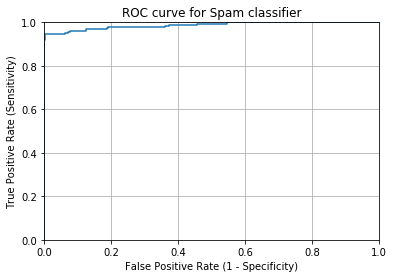

In [45]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Spam classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [46]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9866431000536962

## Part 6: Comparing models

We will compare multinomial Naive Bayes with **logistic regression**:

Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [47]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [48]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

/usr/lib/python3/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 86.1 ms, sys: 0 ns, total: 86.1 ms
Wall time: 326 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [49]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [50]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01269556, 0.00347183, 0.00616517, ..., 0.03354907, 0.99725053,
       0.00157706])

In [51]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9877961234745154

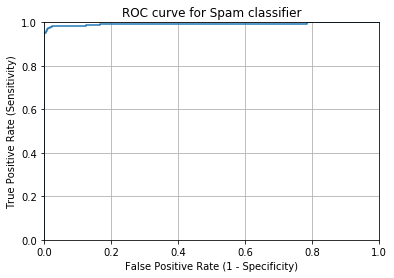

In [52]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Spam classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [53]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9936817612314301

## Part 7: Examining a model for further insight
We will examine the our **trained Naive Bayes model** to calculate the approximate **"spamminess" of each token**.

In [54]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

7456

In [55]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['00', '000', '008704050406', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06', '07', '07008009200', '07090201529', '07090298926', '07123456789', '07732584351', '07734396839', '07742676969', '0776xxxxxxx', '07781482378', '07786200117', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '07880867867', '0789xxxxxxx', '07946746291', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '08', '0800', '08000407165', '08000776320', '08000839402', '08000930705']


In [56]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['yer', 'yes', 'yest', 'yesterday', 'yet', 'yetunde', 'yijue', 'ym', 'ymca', 'yo', 'yoga', 'yogasana', 'yor', 'yorge', 'you', 'youdoing', 'youi', 'youphone', 'your', 'youre', 'yourjob', 'yours', 'yourself', 'youwanna', 'yowifes', 'yoyyooo', 'yr', 'yrs', 'ything', 'yummmm', 'yummy', 'yun', 'yunny', 'yuo', 'yuou', 'yup', 'zac', 'zaher', 'zealand', 'zebra', 'zed', 'zeros', 'zhong', 'zindgi', 'zoe', 'zoom', 'zouk', 'zyada', 'èn', '〨ud']


In [57]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 5., 23.,  2., ...,  0.,  0.,  0.]])

In [58]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 7456)

In [59]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([0., 0., 0., ..., 1., 1., 1.])

In [60]:
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([ 5., 23.,  2., ...,  0.,  0.,  0.])

In [61]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'ham':ham_token_count, 'spam':spam_token_count}).set_index('token')
tokens.head(10)

,ham,spam
token,,
00,0.0,5.0
000,0.0,23.0
008704050406,0.0,2.0
0121,0.0,1.0
01223585236,0.0,1.0
01223585334,0.0,2.0
0125698789,1.0,0.0
02,0.0,4.0
0207,0.0,3.0


In [62]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,64.0,2.0
nasty,1.0,1.0
villa,0.0,1.0
beloved,1.0,0.0
textoperator,0.0,2.0


In [63]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([3617.,  562.])

Before we can calculate the "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [64]:
# add 1 to ham and spam counts to avoid dividing by 0
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,65.0,3.0
nasty,2.0,2.0
villa,1.0,2.0
beloved,2.0,1.0
textoperator,1.0,3.0


In [65]:
# convert the ham and spam counts into frequencies
tokens['ham'] = tokens.ham / nb.class_count_[0]
tokens['spam'] = tokens.spam / nb.class_count_[1]
tokens.sample(5, random_state=6)

,ham,spam
token,,
very,0.017971,0.005338
nasty,0.000553,0.003559
villa,0.000276,0.003559
beloved,0.000553,0.001779
textoperator,0.000276,0.005338


In [66]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens.spam / tokens.ham
tokens.sample(5, random_state=6)

,ham,spam,spam_ratio
token,,,
very,0.017971,0.005338,0.297044
nasty,0.000553,0.003559,6.435943
villa,0.000276,0.003559,12.871886
beloved,0.000553,0.001779,3.217972
textoperator,0.000276,0.005338,19.307829


In [67]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values('spam_ratio', ascending=False)

,ham,spam,spam_ratio
token,,,
claim,0.000276,0.158363,572.798932
prize,0.000276,0.135231,489.131673
150p,0.000276,0.087189,315.361210
tone,0.000276,0.085409,308.925267
guaranteed,0.000276,0.076512,276.745552
18,0.000276,0.069395,251.001779
cs,0.000276,0.065836,238.129893
www,0.000553,0.129893,234.911922
1000,0.000276,0.056940,205.950178


In [68]:
# look up the spam_ratio for a given token
tokens.loc['dating', 'spam_ratio']

83.66725978647686

## Part 8: Tuning the vectorizer
Thus far, we have been using the default parameters of **CountVectorizer**:

In [69]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words**: string {'english'}, list, or None (default)
 -  If 'english', a built-in stop word list for English is used.
 -  If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
 -  If None, no stop words will be used.

In [70]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

- **ngram_range**: tuple (min_n, max_n), default=(1, 1)
 - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
 - All values of n such that min_n <= n <= max_n will be used.

In [71]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

- **max_df**: float in range [0.0, 1.0] or int, default=1.0
 - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
 - If float, the parameter represents a proportion of documents.
 - If integer, the parameter represents an absolute count.

In [72]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- **min_df**: float in range [0.0, 1.0] or int, default=1
 - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
 - If float, the parameter represents a proportion of documents.
 - If integer, the parameter represents an absolute count.

In [73]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

**Guidelines for tuning CountVectorizer**:

- Use your knowledge of the problem and the text, and your understanding of the tuning parameters, to help you decide what parameters to tune and how to tune them.
- Experiment, and let the data tell you the best approach!